<a href="https://colab.research.google.com/github/EtzionR/LM4GeoAI/blob/main/Geo_Semantic_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install osmnx

In [53]:
from time import time as get_time
from transformers import pipeline
from shapely import Point
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import osmnx as ox
import numpy as np

In [54]:
FOOD = {'restaurant','fast_food','cafe'}
FOOD

{'cafe', 'fast_food', 'restaurant'}

In [55]:
place = "Paris, France"

tags = {"amenity": True}

In [56]:
START = get_time()

pois = ox.features_from_place(place, tags)

END = get_time()

In [57]:
pois = pois[['name', 'amenity', 'geometry']].dropna().rename(columns={'amenity':'place_type'}).to_crs("EPSG:32631")
pois['IsFood'] = pois.place_type.apply(lambda value: value in FOOD)
print(f'Time to extarct data from OSM: {round(END-START,1)} seconds ({round((END-START)/60,1)} minutes)\n\n')

pois.shape

Time to extarct data from OSM: 132.9 seconds (2.2 minutes)




(26498, 4)

In [58]:
pois.head()

name      place_type  \
element id                                                         
node    21662099                      Notre-Dame  ferry_terminal   
        24910582  Embarcadère du Chalet des Îles  ferry_terminal   
        25213384       Relais Total Du Pont Aval            fuel   
        25214653        Relais des Chaufourniers            fuel   
        27415802                 Paris 17 Wagram     post_office   

                                        geometry  IsFood  
element id                                                
node    21662099  POINT (452320.712 5411188.723)   False  
        24910582  POINT (445834.511 5412487.964)   False  
        25213384  POINT (446146.834 5409337.476)   False  
        25214653  POINT (453864.466 5414327.112)   False  
        27415802  POINT (448842.707 5414715.887)   False

In [59]:
is_food_rate = round(pois.IsFood.mean()*100,1)

print(f'{is_food_rate}% of POIs place_type are "Food related" (place_type = {FOOD})')


52.5% of POIs place_type are "Food related" (place_type = {'restaurant', 'fast_food', 'cafe'})


In [60]:
pois.place_type.value_counts().head(10)

,count
place_type,
restaurant,8758
fast_food,2754
cafe,2408
bar,1799
school,1234
bicycle_rental,1052
bank,912
pharmacy,874
social_facility,461


In [61]:
MODEL = "intfloat/multilingual-e5-large"

TEXT = "restaurant"

embedder = pipeline("feature-extraction", model=MODEL)

get_text_embedding = lambda text: np.array(embedder(text)[0]).max(0)

get_text_embedding(TEXT)

Device set to use cpu


array([ 1.23215318,  0.75919527, -0.22321977, ..., -0.21436638,
       -0.85060573,  1.06850529])

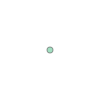

In [62]:
# Eiffel Tower ("Tour Eiffel")

# WGS84 GEO DD X = 2.2952925, Y = 48.8581082
# WGS84 GEO UTM 31N X = 448315, Y = 5411949

EIFFEL = Point(448315, 5411949)
EIFFEL

In [63]:
pois['distance_from_eiffel'] = pois.geometry.distance(EIFFEL).round(2)
pois.head()

name      place_type  \
element id                                                         
node    21662099                      Notre-Dame  ferry_terminal   
        24910582  Embarcadère du Chalet des Îles  ferry_terminal   
        25213384       Relais Total Du Pont Aval            fuel   
        25214653        Relais des Chaufourniers            fuel   
        27415802                 Paris 17 Wagram     post_office   

                                        geometry  IsFood  distance  
element id                                                          
node    21662099  POINT (452320.712 5411188.723)   False   4077.22  
        24910582  POINT (445834.511 5412487.964)   False   2538.37  
        25213384  POINT (446146.834 5409337.476)   False   3394.26  
        25214653  POINT (453864.466 5414327.112)   False   6037.55  
        27415802  POINT (448842.707 5414715.887)   False   2816.76

In [64]:
eiffel_radius = pois[pois['distance_from_eiffel']<2000]
eiffel_radius.shape

(2528, 5)

In [ ]:
eiffel_radius['repr'] = [get_text_embedding(text) for text in tqdm(eiffel_radius.name)]

eiffel_radius.head()

  8%|▊         | 195/2528 [01:42<15:04,  2.58it/s]

In [ ]:
food = get_text_embedding("I want something to eat")

cosine_similarity = lambda vec1, vec2: np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

eiffel_radius['L2'] = eiffel_radius.repr.apply(lambda ary: ((food-ary)**2).mean())
eiffel_radius['L1'] = eiffel_radius.repr.apply(lambda ary:  np.abs(food-ary).mean())
eiffel_radius['CS'] = eiffel_radius.repr.apply(lambda ary:  1-cosine_similarity(food,ary))
eiffel_radius['Random'] = np.random.rand(eiffel_radius.shape[0])

eiffel_radius.head()

In [ ]:

Ks = [5, 10, 25, 50, 75, 100, 200, 1000, len(eiffel_radius)]

required_columns = [*eiffel_radius.columns[-4:]]+['distance_from_eiffel']

evaluation = {method:{k:0 for k in Ks} for method in required_columns}

for method in required_columns:
    for k in Ks:
      evaluation[method][k] = eiffel_radius.sort_values(method).IsFood[:k].mean()

evaluation = pd.DataFrame(evaluation)*100
evaluation.round(1)


In [ ]:
Ks = [5]+[*range(100, len(eiffel_radius), 100)]+[len(eiffel_radius)]

required_columns = [*eiffel_radius.columns[-4:]]+['distance_from_eiffel']

evaluation = {method:{k:0 for k in Ks} for method in required_columns}

for method in required_columns:
    for k in Ks:
      evaluation[method][k] = eiffel_radius.sort_values(method).IsFood[:k].mean()

evaluation = pd.DataFrame(evaluation)*100

# ##############################################################################

for col in evaluation.columns:

    plt.plot(evaluation.index, evaluation[col], label=col if col!='distance_from_eiffel' else 'Naive distance')

for yi in np.linspace(0,100,11):
    plt.plot([0,len(eiffel_radius)],[yi,yi], color='gray', alpha=.4, zorder=-1)

for xi in np.arange(0,len(eiffel_radius),250):
    plt.plot([xi, xi],[0,100], color='gray', alpha=.4, zorder=-1)

plt.xlabel('The number of retrived POIs (K)')
plt.ylabel('Precision@K (%)')

plt.legend(loc='lower left')
plt.ylim(0,101)
plt.xlim(0,len(eiffel_radius))

plt.show()

